# Topic Modeling

Purpose: Given metadata from TikTok ad videos, determine the prominent topics within ads using LDA.  
Author: Eni Mustafaraj and Lillie Godinez

**Outline**  
1. [Load the data](#load)  
2. [Create doc dataframe](#docdf)  
3. [Initialize the CountVectorizer](#countvec)  
4. [Fit the LDA model](#lda)  
5. [Visualizations](#vis)
6. [Grid search](#grid)

Import packages

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

<a name="load"></a>
## Load the data

We have a csv file where each line represents a video and each column is the metadata for that video collected via Pyktok. These ads are across 19 Wellesley College students aged 18-24.

In [3]:
df = pd.read_csv('all_ads.csv')
df.head()

,Unnamed: 0.1,video_id,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,...,author_name,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,hashtags,data_user,Unnamed: 0
0,23,7.340000e+18,2024-03-01T11:42:38,15.0,FAKE-AD,"walking pretty, Walking Shoes, Walking On Water",675.0,10.0,8.0,954100.0,...,Athleta,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
1,26,7.320000e+18,2023-12-21T20:47:42,27.0,US,"christina stratton, christinastrat, Scrubs Dov...",1404.0,5.0,11.0,390700.0,...,christina stratton,NaN,NaN,NaN,NaN,NaN,False,"DovePartner, DoveLove",NaN,NaN
2,43,7.340000e+18,2024-02-26T17:06:19,15.0,FAKE-AD,"disney movies, raiden shogun, Disney Shows, Di...",11000.0,112.0,174.0,17500000.0,...,DisneyPlus,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
3,59,7.340000e+18,2024-02-28T14:47:57,6.0,FAKE-AD,"cushion, Cushion Foundation, Cushion Recommend...",512.0,3.0,4.0,1300000.0,...,U by Kotex,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
4,66,7.330000e+18,2024-02-09T13:19:38,14.0,FAKE-AD,"Southwest Airlines, Banquette Seating, Southwe...",33100.0,346.0,328.0,77300000.0,...,Southwest Airlines®,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN


<a name="docdf"></a>
## Create a new dataframe with the documents

Each document is going to be the combined text from suggested words and video description for the corresponding video.

In [5]:
docList = [] # to hold the new documents

for i in df.index:
    sugwords = df.iloc[i]['suggested_words']
    viddes = df.iloc[i]['video_description']
    
    # turn NaN values into empty strings to avoid errors
    if type(sugwords) != str:
        sugwords = ''
    if type(viddes) != str:
        viddes = ''
    
    # combine with a space in between to avoid creating nonwords
    combined = sugwords + " " + viddes
    docList.append(combined)

This new dataframe holds the documents for all videos.

In [6]:
allDocs = pd.DataFrame(docList,columns=['document'])
allDocs.head()

,document
0,"walking pretty, Walking Shoes, Walking On Wate..."
1,"christina stratton, christinastrat, Scrubs Dov..."
2,"disney movies, raiden shogun, Disney Shows, Di..."
3,"cushion, Cushion Foundation, Cushion Recommend..."
4,"Southwest Airlines, Banquette Seating, Southwe..."


<a name="countvec"></a>
## Initialize the CountVectorizer

Create a CountVectorizer object that removes stop words, lowercases letters, and keeps only words that are 3 or more characters long. 

Then, we fit the vectorizer using our dataframe of documents to create a document-term matrix.

In [7]:
# Initialize the vectorizer
vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b', # we want only words that contain letters and are 3 or more characters long
)

# Transform our data into the document-term matrix
dtm = vectorizer.fit_transform(allDocs['document'])
dtm

<23937x23163 sparse matrix of type '<class 'numpy.int64'>'
	with 315435 stored elements in Compressed Sparse Row format>

In [8]:
def matrix2Doc(dtMatrix, features, index):
    """Turns each row of the document-term matrix into a list of terms"""
    row = dtMatrix.getrow(index).toarray()
    non_zero_indices = row.nonzero()[1]
    words = [features[idx] for idx in non_zero_indices]
    return words

Extract feature names and add to our document dataframe the terms associated with each doc that were extracted using the CountVectorizer.

In [ ]:
feature_names = vectorizer.get_feature_names_out()
allDocsAsTerms = [matrix2Doc(dtm, feature_names, i) for i in range(dtm.shape[0])]

<a name="lda"></a>
## Fitting an LDA model using our doc-term matrix

In [11]:
# Step 1: Initialize the model

lda = LatentDirichletAllocation(n_components=4, # we are picking the number of topics arbitrarely at the moment
                                random_state=0)

# Step 2: Fit the model
lda.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=0)

In [12]:
def display_topics(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([features[i]
                        for i in topic.argsort()[:-no_top_words-1:-1]])) # syntax for reversing a list [::-1]

display_topics(lda, feature_names, 40)

Topic 0:
body pet coffee products dove new tiktok delivery care taco dog bell best candy app videos sweet pants things skin cream good foundation breakfast day food halara skincare hair wash protein chocolate sephora pets cerave make cute clean poor marshalls
Topic 1:
new deodorant makeup lip day free butter food love ideas make color gift gloss easy best foundation period essence recipe recipes try tiktok rice snack science snacks fyp peanut covergirl good sandwich body cheese time night just brow skin powder
Topic 2:
amazon skin finds shop disney skincare hair tiktok products care new bag water mascara shopping maxx home outfit denim serum outfits neutrogena cream routine summer olay body best clothes dune tote makeup walmart beauty tea boost lip bags decor movie
Topic 3:
dress pizza game new nails press fashion hair super taylor lip bowl balm monopoly movie usher swift free brush body skittles perfume prada best cleaning tiktok bag dominos elementary nail gummies abbott opi review c

In [13]:
def displayHeader(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    topicNames = []
    for topic_idx, topic in enumerate(model.components_):
        topicNames.append(f"Topic {topic_idx}: " + (", ".join([features[i]
                             for i in topic.argsort()[:-no_top_words-1:-1]])))
    return topicNames

doc_topic_dist = lda.transform(dtm)

topicnames = displayHeader(lda, feature_names, 5)

# index names
docnames = allDocs.index.tolist() # We will use the original names of the documents

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 3),
                                 columns=topicnames,
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1) # finds the maximum argument
df_document_topic['dominant_topic'] = dominant_topic

How many documents are sorted into each topic?

In [14]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,6225
1,2,6217
2,0,6068
3,3,5427


<a name="vis"></a>
## Visualize the results

I wanted to create a visualization similar to one I found on BERTopics. Thus, this section will calculate the top words for each topic and how many times they are repeated and then visualize that in a horizontal bar graph.

In [56]:
numTopics=len(lda.components_) #gets the number of topics, even if the parameter is changed
numWords = 10 #change to visualize more words

listOfResults = []
for i in range(numTopics):
    # for each topic, use the makeTopWord function to calculate 
    # the values for top words
    listOfResults.append(makeTopWord(i,numWords))

In [57]:
def makeTopWord(topicNum,numWords):
    """
    Given the number of top words desired and the number of topics, 
    sort the feature names based on occurrance. Then create a dictionary 
    that returns the value of word occurance as a value and the word as a key.
    """
    commonWords = np.flip(feature_names[lda.components_[topicNum].argsort()])[:numWords]
    wordProb = sorted(lda.components_[topicNum],reverse=True)[:numWords]
    
    result_dict = {commonWords[i]: wordProb[i] for i in range(len(commonWords))}
    
    return result_dict

In [74]:
def makeTopWordFig(listOfResults):
    """
    Using the dictionary of most common words with occurance values
    for each topic, create a figure that visualizes this data using  
    subplots.
    """
    num_topics = len(listOfResults)
    num_cols = 2  # Two columns for subplots
    num_rows = -(-num_topics // num_cols)  # Ceiling division to calculate number of rows
    
    # initialize subplot figure
    f, axs = plt.subplots(num_rows, num_cols, sharey=False, figsize=(5*num_cols, 5*num_rows))
    colors = ['red', 'orange', 'blue', 'yellow', 'green']
    
    # for each topic, separate out the items in the dictionary 
    # then index the figure axes to plot the information
    for i, result in enumerate(listOfResults):
        row = i // num_cols
        col = i % num_cols
        x = list(result.keys())
        y = list(result.values())
        if num_rows == 1:  # If only one row, axs is a 1D array
            axs[col].barh(x, y, color=colors[i])
            axs[col].set_title(f'Topic: {i}')
        else:  # If more than one row, axs is a 2D array
            axs[row, col].barh(x, y, color=colors[i])
            axs[row, col].set_title(f'Topic: {i}')
            axs[row, col].invert_yaxis()
    
    # Hide empty subplots if any
    if num_topics < num_rows * num_cols:
        for i in range(num_topics, num_rows * num_cols):
            if num_rows == 1:
                axs[i].axis('off')
            else:
                axs.flat[i].axis('off')
    
    plt.rcParams['font.size'] = 15
    plt.tight_layout()
    plt.show()

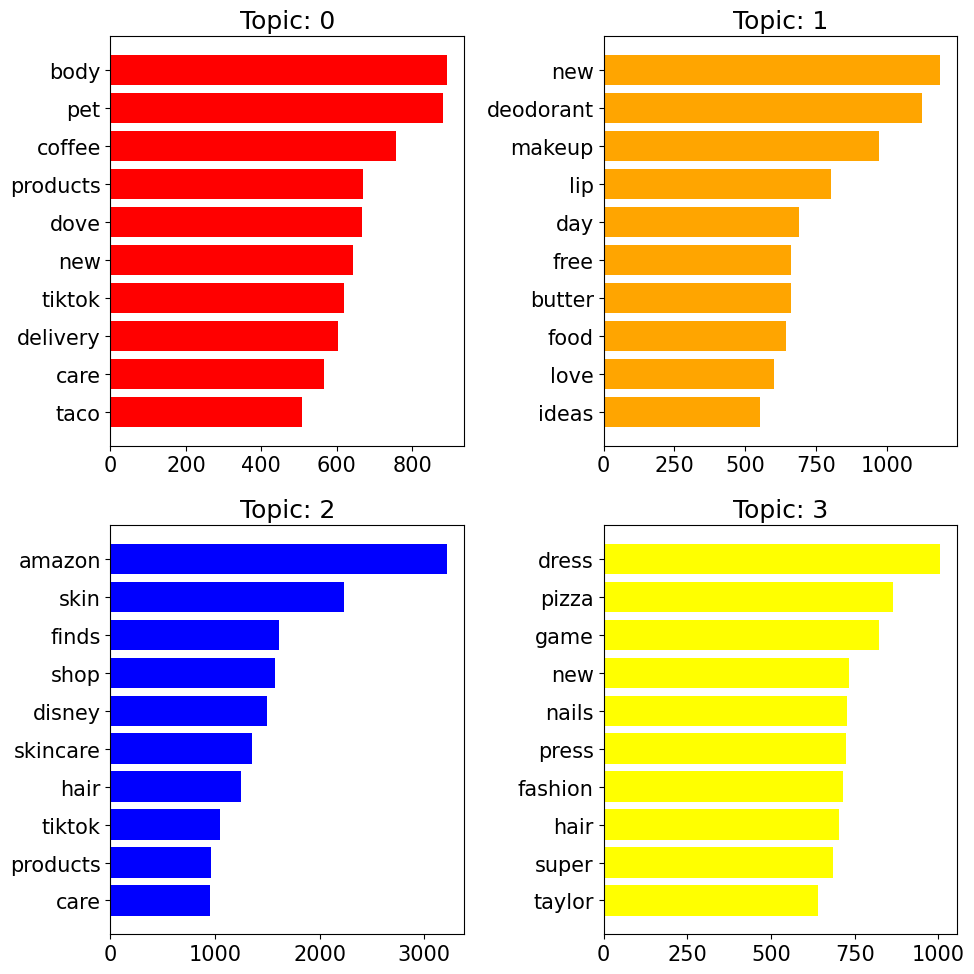

In [75]:
makeTopWordFig(listOfResults)

<a name="grid"></a>
## Grid Search

Grid search allows us to test different parameters for the number of topics.

In [29]:
# We are going to test multiple values for the number of topics
search_params1 = {'n_components': [5, 10, 15, 20, 25, 30, 35]}
search_params2 = {'n_components': [1,2,3,4,5,6]}

# Initialize the LDA model
lda = LatentDirichletAllocation()

# Initialize a Grid Search with cross-validation instance
grid = GridSearchCV(lda, param_grid=search_params2)

# Do the Grid Search
#grid.fit(dtm)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6]})

The result of our grid search is 1 topic, which is likely because we don't have enough data to work with. So, we will manually decide the number of topics by evaluating the results at different values of n. 

In [30]:
# Best Model
best_lda_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

Best Model's Params:  {'n_components': 1}
Best Log Likelihood Score:  -837193.5588827628
Model Perplexity:  4534.857031869271
